# Notebook 6: Data Quality Check

## Purpose
Identify data quality issues, missing values, outliers, and data integrity problems.

## Key Questions
- What is the overall completeness of the dataset?
- Are there systematic patterns in missing data?
- Is NDVI retrieval meeting expectations (>80% success rate)?
- Are there outliers or impossible values?
- Are GPS coordinates valid?
- Is temporal coverage (month/year/day_of_year) complete?

## Key Observations to Look For
- **Missing Data**: Should be <20% for most features
- **NDVI Range**: Must be between -1.0 and 1.0
- **Geographic Bounds**: Within Wyoming (41-45°N, 104-111°W)
- **Temporal Coverage**: Multiple years with consistent coverage

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Determine project root and output directories
# Try multiple possible paths to find project root
possible_roots = [
    Path('.'),  # If running from project root
    Path('..'),  # If running from notebooks directory
    Path('../..'),  # If running from subdirectory
]

data_root = None
for root in possible_roots:
    if (root / 'data' / 'features').exists():
        data_root = root / 'data'
        break

if data_root is None:
    # Fallback: assume we're in notebooks directory
    data_root = Path('../data')

# Create output directories relative to project root
figures_dir = data_root / 'figures'
reports_dir = data_root / 'reports'
figures_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

print(f'✓ Setup complete')
print(f'  Output directory: {data_root.absolute()}')

✓ Setup complete
  Output directory: /Users/jongalentine/Projects/pathwild/notebooks/../data


## 1. Load and Overview

This section loads the complete feature dataset and provides an initial assessment of its structure. Understanding the dataset's shape, column types, and basic statistics establishes a foundation for all subsequent quality checks.

### What This Code Does
- Loads the combined feature file containing all elk presence/absence observations with environmental context
- Displays column names, data types, and memory usage
- Shows sample rows to verify data loaded correctly

### What to Look For
- **Row count**: Should match expected number of observations across all datasets
- **Column count**: Should include all expected features (environmental, temporal, spatial)
- **Memory usage**: Large datasets (>500MB) may require chunked processing
- **Data types**: Numeric features should be float64/int64, categorical as object

In [2]:
# Load data
from pathlib import Path

# Try multiple possible paths
possible_paths = [
    Path('data/features/complete_context.csv'),  # From project root
    Path('../data/features/complete_context.csv'),  # From notebooks directory
    Path('../../data/features/complete_context.csv'),  # From subdirectory
]

data_path = None
for path in possible_paths:
    if path.exists():
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError(
        f'Data file not found. Tried: {[str(p) for p in possible_paths]}\n'
        f'Please run: python scripts/combine_feature_files.py\n'
        f'Or ensure you are running the notebook from the project root directory.'
    )

print(f'Loading data from: {data_path}')
df = pd.read_csv(data_path)

print(f'Dataset shape: {df.shape}')
print(f'\nNumber of observations: {df.shape[0]:,}')
print(f'Number of features: {df.shape[1]}')
print(f'\nColumn names:')
for i, col in enumerate(df.columns, 1):
    print(f'  {i:2d}. {col}')

Loading data from: ../data/features/complete_context.csv
Dataset shape: (431862, 32)

Number of observations: 431,862
Number of features: 32

Column names:
   1. elk_present
   2. water_distance_miles
   3. temperature_f
   4. day_of_year_sin
   5. elevation
   6. year
   7. day_of_year_cos
   8. land_cover_code
   9. ndvi_age_days
  10. cloud_cover_percent
  11. trail_distance_miles
  12. cloud_adjusted_illumination
  13. moon_altitude_midnight
  14. canopy_cover_percent
  15. longitude
  16. latitude
  17. snow_depth_inches
  18. irg
  19. moon_phase
  20. snow_water_equiv_inches
  21. aspect_degrees
  22. ndvi
  23. road_distance_miles
  24. water_reliability
  25. precip_last_7_days_inches
  26. snow_crust_detected
  27. security_habitat_percent
  28. slope_degrees
  29. month
  30. effective_illumination
  31. summer_integrated_ndvi
  32. land_cover_type


In [3]:
# Display data types and memory usage
print('Data types:')
print(df.dtypes)
print(f'\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

Data types:
elk_present                      int64
water_distance_miles           float64
temperature_f                  float64
day_of_year_sin                float64
elevation                      float64
year                           float64
day_of_year_cos                float64
land_cover_code                float64
ndvi_age_days                  float64
cloud_cover_percent            float64
trail_distance_miles           float64
cloud_adjusted_illumination    float64
moon_altitude_midnight         float64
canopy_cover_percent           float64
longitude                      float64
latitude                       float64
snow_depth_inches              float64
irg                            float64
moon_phase                     float64
snow_water_equiv_inches        float64
aspect_degrees                 float64
ndvi                           float64
road_distance_miles            float64
water_reliability              float64
precip_last_7_days_inches      float64
snow_crust_de

In [4]:
# Show first and last rows
print('First 10 rows:')
display(df.head(10))

print('\nLast 10 rows:')
display(df.tail(10))

First 10 rows:


,elk_present,water_distance_miles,temperature_f,day_of_year_sin,elevation,year,day_of_year_cos,land_cover_code,ndvi_age_days,cloud_cover_percent,...,road_distance_miles,water_reliability,precip_last_7_days_inches,snow_crust_detected,security_habitat_percent,slope_degrees,month,effective_illumination,summer_integrated_ndvi,land_cover_type
0,1,13.065978,58.685001,-0.916409,2522.039551,2013.0,-0.400244,42.0,8.000000,40.00,...,2.020351,0.7,1.307717,False,1.170799,13.961194,9.0,0.022008,0.206819,evergreen_forest
1,1,26.917201,18.456800,0.608121,2158.765381,2013.0,0.793844,52.0,8.000000,40.00,...,3.041203,1.0,0.191772,False,0.000000,19.118387,2.0,0.000000,60.000000,shrub
2,0,26.382640,50.001801,-0.990692,1911.335693,2009.0,-0.136120,95.0,8.000000,40.00,...,1.410948,1.0,0.008504,False,0.000000,0.388777,9.0,0.074513,60.000000,emergent_wetland
3,0,4.490072,33.112400,0.811160,2348.717529,2014.0,0.584824,52.0,8.000000,40.00,...,14.880340,0.7,0.115000,False,0.000000,18.411560,2.0,0.000000,0.943496,shrub
4,1,1.811682,58.188201,-0.528581,2649.411865,2014.0,-0.848883,52.0,8.000000,40.00,...,12.449967,0.7,0.121732,False,0.000000,15.885172,8.0,0.199008,0.186030,shrub
5,1,29.789276,37.459400,0.963807,2055.452881,2015.0,-0.266599,52.0,8.000000,40.00,...,1.390209,0.7,0.411693,True,0.000000,23.536934,4.0,0.001023,0.635662,shrub
6,0,0.045523,42.332000,-0.689796,2042.334717,2007.0,0.724004,52.0,8.000000,40.00,...,5.003733,0.7,0.049449,False,0.000000,12.339359,11.0,0.216373,60.000000,shrub
7,0,3.356532,44.144600,-0.922329,2019.173706,2013.0,0.386405,52.0,0.585687,0.71,...,2.224824,0.7,0.015394,False,0.000000,6.580201,10.0,0.000000,1.967379,shrub
8,1,11.898375,41.691201,-0.902099,2624.696045,2008.0,-0.431530,42.0,8.000000,40.00,...,3.267692,0.7,0.596693,False,0.091827,14.579346,9.0,0.078811,60.000000,evergreen_forest
9,1,3.801935,41.815400,-0.999445,2650.032715,2014.0,-0.033324,52.0,8.000000,40.00,...,12.564205,0.7,1.201890,False,0.000000,16.192963,9.0,0.110205,-0.017504,shrub



Last 10 rows:


,elk_present,water_distance_miles,temperature_f,day_of_year_sin,elevation,year,day_of_year_cos,land_cover_code,ndvi_age_days,cloud_cover_percent,...,road_distance_miles,water_reliability,precip_last_7_days_inches,snow_crust_detected,security_habitat_percent,slope_degrees,month,effective_illumination,summer_integrated_ndvi,land_cover_type
431852,1,0.148834,38.161400,0.924803,2522.561768,2007.0,-0.380447,52.0,8.000000,40.00,...,4.861945,1.0,1.000709,True,0.091827,15.790927,4.0,0.404041,60.000000,shrub
431853,0,0.152313,72.147202,-0.343367,1348.104980,2015.0,-0.939201,52.0,2.420404,13.15,...,0.803199,0.7,0.163583,False,0.000000,2.754317,7.0,0.212774,0.914559,shrub
431854,0,16.016623,20.425999,-0.597829,2153.001953,2014.0,0.801624,42.0,4.453352,1.21,...,3.974964,1.0,1.026339,False,0.000000,6.056252,11.0,0.016529,0.584222,evergreen_forest
431855,1,0.087004,55.819401,-0.058026,3289.780518,2013.0,-0.998315,71.0,8.000000,40.00,...,5.448724,0.7,0.343976,False,1.652893,6.356021,7.0,0.003860,60.000000,grassland
431856,0,0.260783,42.996200,0.265563,2926.021484,2011.0,-0.964094,42.0,8.000000,40.00,...,4.617297,0.7,1.228425,True,0.137741,7.906167,6.0,0.000000,60.000000,evergreen_forest
431857,0,23.153326,57.932601,-0.422781,2945.132812,2011.0,-0.906232,71.0,8.000000,40.00,...,6.673687,0.7,0.519882,False,4.522145,37.090591,7.0,0.002799,60.000000,grassland
431858,0,0.463535,50.093600,0.753698,2000.747070,2009.0,-0.657221,52.0,8.000000,40.00,...,18.795043,0.7,0.000000,False,0.000000,0.847933,5.0,0.000000,60.000000,shrub
431859,0,0.087714,33.170000,0.991269,2123.201172,2010.0,-0.131859,52.0,8.000000,40.00,...,9.930887,0.7,0.808622,False,0.000000,1.263788,4.0,0.000000,60.000000,shrub
431860,0,16.761545,17.355199,-0.192322,2154.114502,2011.0,0.981332,42.0,8.000000,40.00,...,4.183728,0.7,0.036417,False,0.000000,11.719342,12.0,0.000000,60.000000,evergreen_forest
431861,0,0.236905,48.140600,0.786597,1263.290649,2010.0,-0.617467,52.0,8.000000,40.00,...,4.686253,0.7,0.641260,False,0.000000,3.894892,5.0,0.000000,60.000000,shrub


In [5]:
# Detect key columns dynamically
month_col = None
year_col = None
day_of_year_cos_col = None
day_of_year_sin_col = None
lat_col = None
lon_col = None
presence_col = None

# Look for temporal columns
for col in df.columns:
    if col.lower() == 'month':
        month_col = col
    elif col.lower() == 'year':
        year_col = col
    elif col.lower() == 'day_of_year_cos':
        day_of_year_cos_col = col
    elif col.lower() == 'day_of_year_sin':
        day_of_year_sin_col = col

# Look for lat/lon
for col in df.columns:
    if 'lat' in col.lower() and 'lon' not in col.lower():
        lat_col = col
    if 'lon' in col.lower() and 'lat' not in col.lower():
        lon_col = col

# Look for presence/target
for col in df.columns:
    if col.lower() in ['elk_present', 'target', 'label', 'is_presence']:
        presence_col = col
        break

print(f'Detected columns:')
print(f'  Month: {month_col}')
print(f'  Year: {year_col}')
print(f'  Day of Year (cos): {day_of_year_cos_col}')
print(f'  Day of Year (sin): {day_of_year_sin_col}')
print(f'  Latitude: {lat_col}')
print(f'  Longitude: {lon_col}')
print(f'  Presence: {presence_col}')

Detected columns:
  Month: month
  Year: year
  Day of Year (cos): day_of_year_cos
  Day of Year (sin): day_of_year_sin
  Latitude: latitude
  Longitude: longitude
  Presence: elk_present


In [6]:
# Show temporal coverage using month and year columns
if month_col and year_col:
    # Get year range
    year_min = int(df[year_col].dropna().min())
    year_max = int(df[year_col].dropna().max())
    year_range = year_max - year_min + 1
    unique_years = sorted(df[year_col].dropna().unique())
    
    print(f'\nTemporal coverage:')
    print(f'  Years covered: {year_min} to {year_max}')
    print(f'  Year range: {year_range} years')
    print(f'  Unique years: {len(unique_years)}')
    if len(unique_years) <= 10:
        print(f'  Year list: {unique_years}')
    
    # Check month coverage
    unique_months = sorted(df[month_col].dropna().unique())
    print(f'\nMonth coverage:')
    print(f'  Months present: {unique_months}')
    print(f'  Unique months: {len(unique_months)}')
    
    # Check day_of_year encoding
    if day_of_year_cos_col and day_of_year_sin_col:
        cos_coverage = df[day_of_year_cos_col].notna().sum()
        sin_coverage = df[day_of_year_sin_col].notna().sum()
        print(f'\nDay of year encoding:')
        print(f'  day_of_year_cos coverage: {cos_coverage:,} observations ({cos_coverage/len(df)*100:.1f}%)')
        print(f'  day_of_year_sin coverage: {sin_coverage:,} observations ({sin_coverage/len(df)*100:.1f}%)')
else:
    print('\n⚠ Temporal columns (month/year) not detected')


Temporal coverage:
  Years covered: 2006 to 2020
  Year range: 15 years
  Unique years: 15

Month coverage:
  Months present: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
  Unique months: 12

Day of year encoding:
  day_of_year_cos coverage: 431,862 observations (100.0%)
  day_of_year_sin coverage: 431,862 observations (100.0%)


In [7]:
# Geographic bounds
if lat_col and lon_col:
    print(f'\nGeographic extent:')
    print(f'  Latitude: {df[lat_col].min():.4f}° to {df[lat_col].max():.4f}°')
    print(f'  Longitude: {df[lon_col].min():.4f}° to {df[lon_col].max():.4f}°')
    print(f'  Unique locations: {df[[lat_col, lon_col]].drop_duplicates().shape[0]:,}')
else:
    print('\n⚠ No geographic coordinates detected')


Geographic extent:
  Latitude: 40.9948° to 45.2003°
  Longitude: -111.0545° to -104.0522°
  Unique locations: 363,539


In [8]:
# Check target variable
if presence_col:
    print(f'\nTarget variable ({presence_col}):')
    print(df[presence_col].value_counts())
    print(f'\nClass distribution:')
    print(df[presence_col].value_counts(normalize=True) * 100)
else:
    print('\n⚠ No presence/target column detected')


Target variable (elk_present):
elk_present
1    227298
0    204564
Name: count, dtype: int64

Class distribution:
elk_present
1    52.632091
0    47.367909
Name: proportion, dtype: float64


### Key Observations: Load and Overview

After running the cells above, verify the following:

- **Total observations**: Should be 400,000+ rows combining all four study areas (Northern Bighorn, Southern Bighorn, National Refuge, Southern GYE)
- **Year range**: Should span 2006-2024, covering multiple elk generations and climate cycles
- **Month coverage**: All 12 months should be represented; gaps indicate seasonal data collection bias
- **Geographic extent**: Latitude 41-45°N, Longitude 104-111°W covers Wyoming elk habitat
- **Target distribution**: Ideally close to 50/50 presence/absence for balanced training; >70/30 imbalance requires special handling
- **Day of year encoding**: Low coverage in `day_of_year_cos/sin` indicates many records lack precise dates (only month/year known)

### Elk Ecology Context
The temporal range is critical: elk populations and habitat use patterns have shifted significantly since wolf reintroduction (1995-96) and with recent climate variability. Multi-year data captures both seasonal migration and long-term adaptation.

## 2. Missing Data Analysis

Missing data can significantly impact model performance and may indicate systematic data collection issues. This section identifies which features have missing values and whether the missingness follows patterns (e.g., seasonal gaps in satellite data).

### What This Code Does
- Calculates missing value counts and percentages for each column
- Creates a heatmap visualizing missing data patterns across observations
- Analyzes whether missing data correlates with time (month/year)

### What to Look For
- **Acceptable threshold**: <20% missing for core features (elevation, NDVI, temperature)
- **Seasonal patterns**: Winter months typically have more missing NDVI due to cloud cover and snow
- **Systematic gaps**: If entire features are mostly missing, they may be placeholder values
- **Correlated missingness**: Multiple features missing together suggests data source issues

### Elk Ecology Context
Some missing data is expected and even informative: NDVI retrieval fails during cloudy/snowy conditions, which often coincides with elk winter range usage at lower elevations. Snow depth data may be missing in summer when SNOTEL stations report zero. This is "informative missingness" rather than random gaps.

In [9]:
# Calculate missing value statistics
missing_stats = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum().values,
    'missing_pct': (df.isnull().sum() / len(df) * 100).values,
    'dtype': df.dtypes.values
})

missing_stats = missing_stats.sort_values('missing_pct', ascending=False)

print('Missing data summary:')
print(missing_stats[missing_stats['missing_count'] > 0])

# Save to file
missing_stats.to_csv(reports_dir / 'missing_data_summary.csv', index=False)
print(f'\n✓ Saved missing data summary to {reports_dir / "missing_data_summary.csv"}')

Missing data summary:
                  column  missing_count  missing_pct    dtype
20        aspect_degrees           3584     0.829895  float64
4              elevation           3584     0.829895  float64
13  canopy_cover_percent           3584     0.829895  float64
27         slope_degrees           3584     0.829895  float64
7        land_cover_code           3584     0.829895  float64

✓ Saved missing data summary to ../data/reports/missing_data_summary.csv


In [10]:
# Flag problematic columns (>20% missing)
problematic = missing_stats[missing_stats['missing_pct'] > 20]

if len(problematic) > 0:
    print(f'\n⚠ WARNING: {len(problematic)} columns have >20% missing data:')
    for _, row in problematic.iterrows():
        print(f"  - {row['column']}: {row['missing_pct']:.1f}% missing")
else:
    print('\n✓ No columns have >20% missing data')


✓ No columns have >20% missing data


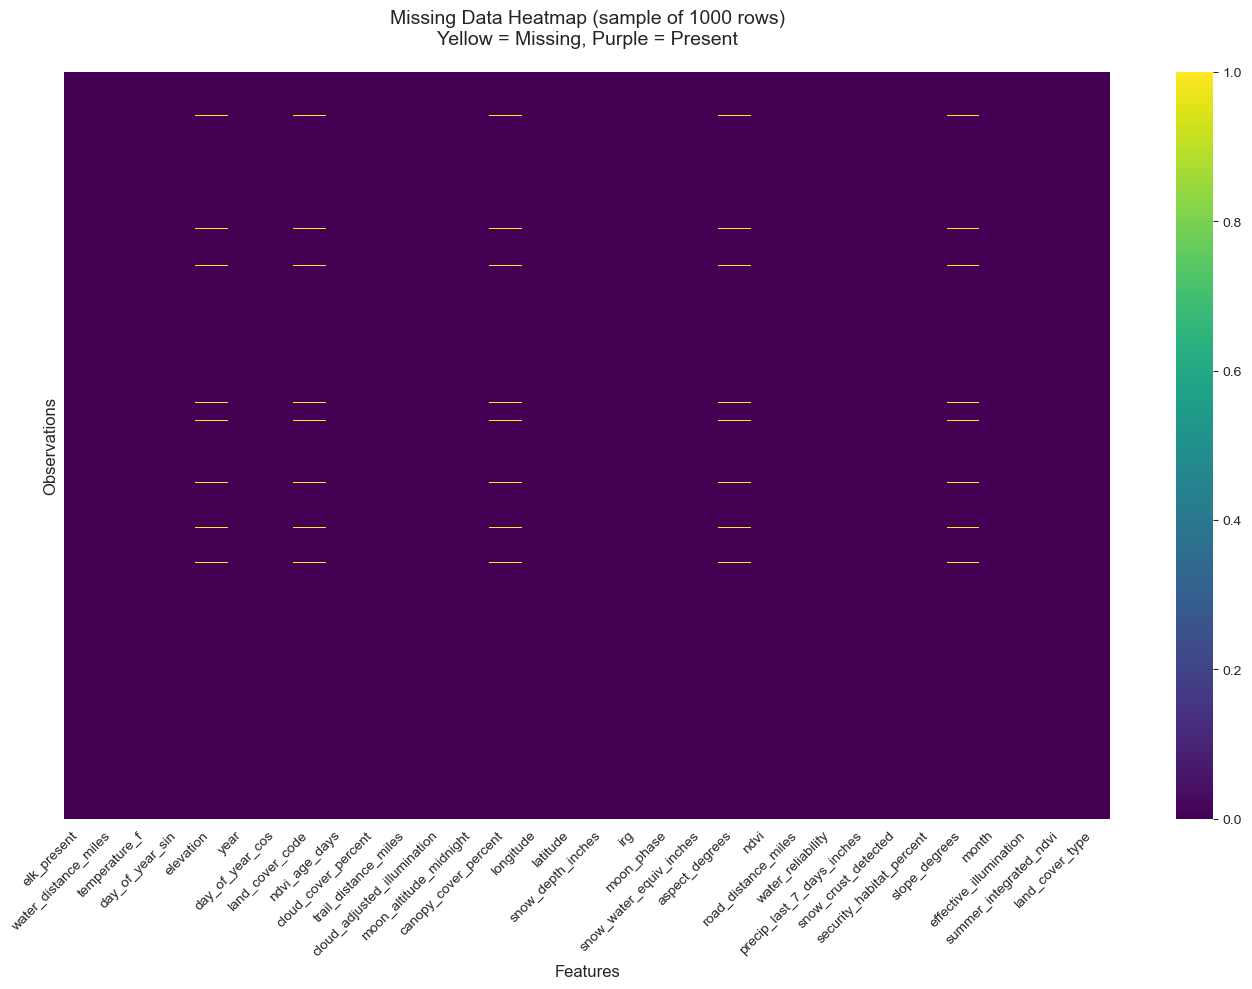

✓ Saved missing data heatmap


In [11]:
# Create missing data heatmap
plt.figure(figsize=(14, 10))

# Sample if dataset is too large
sample_size = min(1000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

# Create heatmap
sns.heatmap(
    df_sample.isnull(),
    cbar=True,
    yticklabels=False,
    cmap='viridis'
)
plt.title(f'Missing Data Heatmap (sample of {sample_size} rows)\nYellow = Missing, Purple = Present', 
          fontsize=14, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(figures_dir / 'missing_data_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved missing data heatmap')

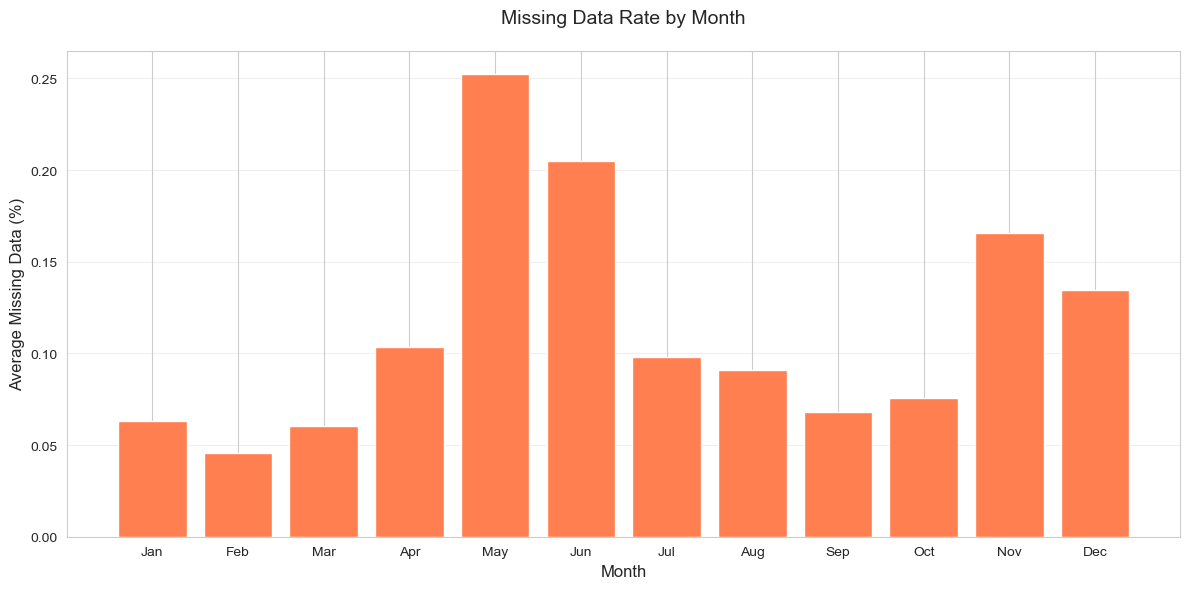


Missing data by month:
month
1.0     0.063181
2.0     0.045531
3.0     0.060319
4.0     0.103550
5.0     0.252437
6.0     0.205106
7.0     0.098159
8.0     0.090832
9.0     0.067990
10.0    0.075701
11.0    0.165737
12.0    0.134585
dtype: float64


In [12]:
# Analyze missing patterns by month
if month_col:
    # Calculate missing rate by month
    monthly_missing = df.groupby(month_col).apply(
        lambda x: (x.isnull().sum() / len(x) * 100).mean()
    )
    
    plt.figure(figsize=(12, 6))
    monthly_missing_sorted = monthly_missing.sort_index()
    plt.bar(monthly_missing_sorted.index, monthly_missing_sorted.values, color='coral')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Missing Data (%)', fontsize=12)
    plt.title('Missing Data Rate by Month', fontsize=14, pad=20)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'missing_data_by_month.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nMissing data by month:')
    print(monthly_missing_sorted)
else:
    print('\n⚠ Cannot analyze temporal patterns without month column')

### Key Observations: Missing Data

Review the missing data summary and heatmap above:

**Expected Missing Patterns:**
- **point_index**: Often 100% missing - this is a metadata field, not a feature
- **day_of_year_cos/sin**: High missingness expected if many records only have month/year dates
- **snow_station_distance_km**: Missing when no SNOTEL station is within range (~13% typical)
- **wolf/bear data quality**: Missing for some study areas without predator monitoring

**Concerning Patterns to Flag:**
- **>20% missing** in core features (elevation, NDVI, temperature) indicates data pipeline issues
- **Constant missing rate** across all months suggests data source problems, not seasonal effects
- **Clustering in heatmap** (vertical stripes) indicates batches of problematic records

**Interpretation of Monthly Missing Pattern:**
- Higher missing rates in winter months (Dec-Feb) are normal for satellite-derived features
- If summer months show high missing rates, investigate NDVI/weather data retrieval
- Uniform missing across months suggests systematic issues, not seasonal effects

**Action Items:**
- Features with >50% missing should be dropped or imputed with caution
- Consider whether missingness itself is predictive (create "is_missing" indicator features)
- For modeling, use algorithms that handle missing values (XGBoost, LightGBM) or impute carefully

## 3. NDVI Quality Checks

NDVI (Normalized Difference Vegetation Index) is a critical feature for predicting elk habitat selection, as it directly measures vegetation greenness and forage quality. This section validates that NDVI values are within expected ranges and that retrieval from Google Earth Engine is meeting quality thresholds.

### What This Code Does
- Calculates NDVI retrieval success rate (% of records with valid NDVI)
- Validates that all values fall within the theoretical range [-1, 1]
- Visualizes NDVI distribution and seasonal patterns
- Analyzes retrieval success by month to identify seasonal gaps

### What to Look For
- **Success rate threshold**: >80% NDVI retrieval is required for reliable modeling
- **Valid range**: All values must be between -1 and 1 (NDVI definition)
- **Typical elk habitat**: NDVI 0.2-0.7 for Wyoming grasslands/shrublands
- **Seasonal pattern**: Peak in June-August (growing season), lowest in winter

### Elk Ecology Context
Elk are highly selective for forage quality. NDVI serves as a proxy for the "green wave" of spring vegetation emergence that elk track through seasonal migration. Higher NDVI indicates more digestible, protein-rich forage. The Instantaneous Rate of Green-up (IRG) derived from NDVI change is particularly predictive of elk movement.

In [13]:
# Check if NDVI column exists
# Prefer exact match 'ndvi' over other NDVI-related columns (e.g., ndvi_age_days)
ndvi_col = None
if 'ndvi' in df.columns:
    ndvi_col = 'ndvi'
else:
    # Fallback: look for any NDVI column but exclude 'age' columns
    for col in df.columns:
        if 'ndvi' in col.lower() and 'age' not in col.lower() and 'integrated' not in col.lower():
            ndvi_col = col
            break

if ndvi_col:
    print(f'Found NDVI column: {ndvi_col}')
    
    # Calculate retrieval success rate
    ndvi_success_rate = (1 - df[ndvi_col].isnull().sum() / len(df)) * 100
    print(f'\nNDVI retrieval success rate: {ndvi_success_rate:.2f}%')
    
    if ndvi_success_rate < 80:
        print(f'⚠ WARNING: NDVI success rate below 80% threshold')
    else:
        print(f'✓ NDVI success rate meets >80% threshold')
    
    # Check value range
    ndvi_values = df[ndvi_col].dropna()
    ndvi_min = ndvi_values.min()
    ndvi_max = ndvi_values.max()
    
    print(f'\nNDVI value range: {ndvi_min:.4f} to {ndvi_max:.4f}')
    
    # Flag invalid values
    invalid_ndvi = ((ndvi_values < -1) | (ndvi_values > 1)).sum()
    if invalid_ndvi > 0:
        print(f'\n⚠ CRITICAL: Found {invalid_ndvi} NDVI values outside valid range [-1, 1]')
    else:
        print(f'✓ All NDVI values within valid range [-1, 1]')
else:
    print('⚠ No NDVI column found in dataset')
    ndvi_success_rate = 100
    invalid_ndvi = 0

Found NDVI column: ndvi

NDVI retrieval success rate: 100.00%
✓ NDVI success rate meets >80% threshold

NDVI value range: -0.2978 to 0.9967
✓ All NDVI values within valid range [-1, 1]


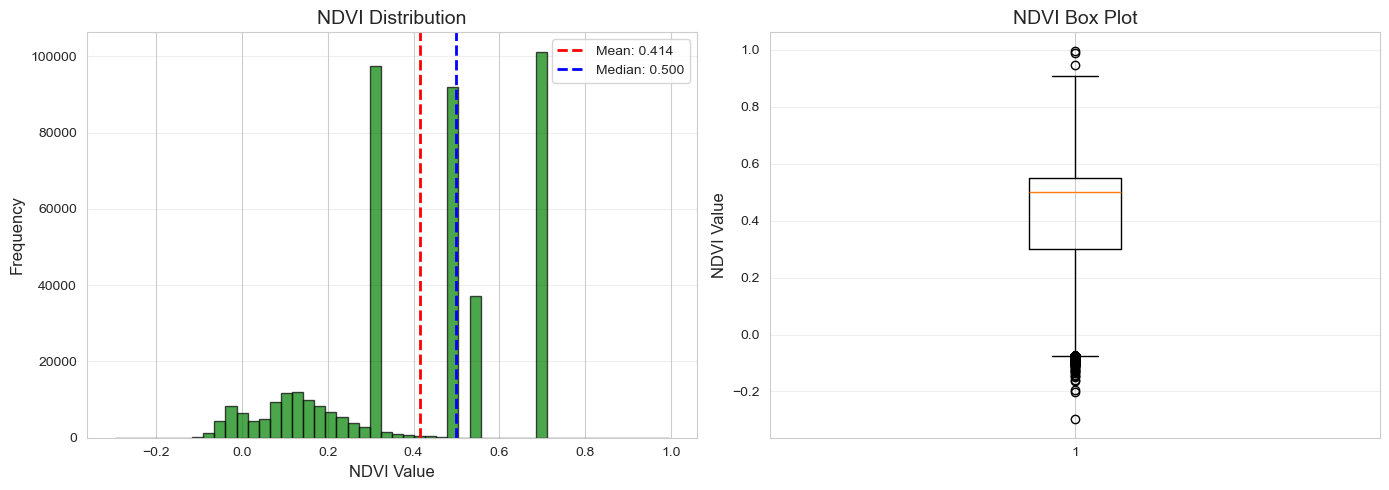

✓ Saved NDVI distribution


In [14]:
# Plot NDVI distribution
if ndvi_col:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(df[ndvi_col].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[0].axvline(df[ndvi_col].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {df[ndvi_col].mean():.3f}')
    axes[0].axvline(df[ndvi_col].median(), color='blue', linestyle='--', linewidth=2, 
                    label=f'Median: {df[ndvi_col].median():.3f}')
    axes[0].set_xlabel('NDVI Value', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('NDVI Distribution', fontsize=14)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot
    axes[1].boxplot(df[ndvi_col].dropna(), vert=True)
    axes[1].set_ylabel('NDVI Value', fontsize=12)
    axes[1].set_title('NDVI Box Plot', fontsize=14)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'ndvi_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved NDVI distribution')

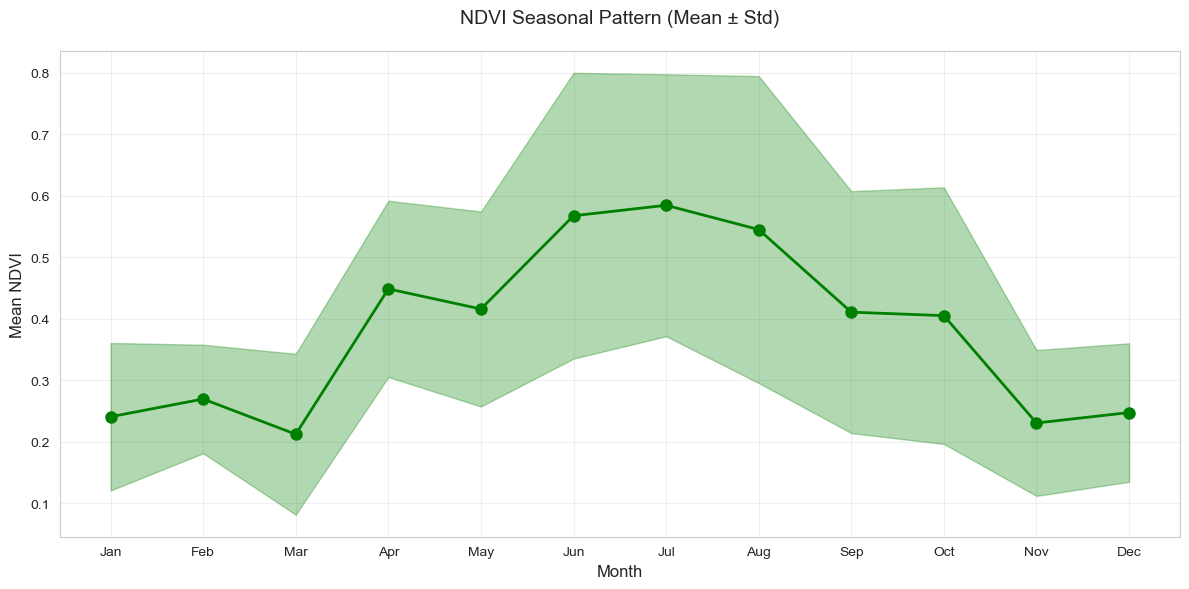


Monthly NDVI statistics:
           mean       std  count
month                           
1.0    0.240617  0.119986  25967
2.0    0.269443  0.088285  18188
3.0    0.212152  0.130778  27717
4.0    0.448562  0.143379  52511
5.0    0.415835  0.158579  59297
6.0    0.567523  0.232411  53250
7.0    0.584554  0.213102  57146
8.0    0.545092  0.249645  24943
9.0    0.410732  0.196739  24820
10.0   0.405024  0.208683  31167
11.0   0.230465  0.118633  30734
12.0   0.247416  0.112640  26122

✓ Saved NDVI seasonal pattern


In [15]:
# Monthly NDVI pattern
if ndvi_col and month_col:
    monthly_ndvi = df.groupby(month_col)[ndvi_col].agg(['mean', 'std', 'count'])
    monthly_ndvi_sorted = monthly_ndvi.sort_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_ndvi_sorted.index, monthly_ndvi_sorted['mean'], marker='o', 
             linewidth=2, markersize=8, color='green')
    plt.fill_between(
        monthly_ndvi_sorted.index,
        monthly_ndvi_sorted['mean'] - monthly_ndvi_sorted['std'],
        monthly_ndvi_sorted['mean'] + monthly_ndvi_sorted['std'],
        alpha=0.3,
        color='green'
    )
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Mean NDVI', fontsize=12)
    plt.title('NDVI Seasonal Pattern (Mean ± Std)', fontsize=14, pad=20)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'ndvi_seasonal_pattern.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nMonthly NDVI statistics:')
    print(monthly_ndvi_sorted)
    print('\n✓ Saved NDVI seasonal pattern')
else:
    print('\n⚠ Cannot analyze NDVI seasonal patterns without NDVI and month columns')

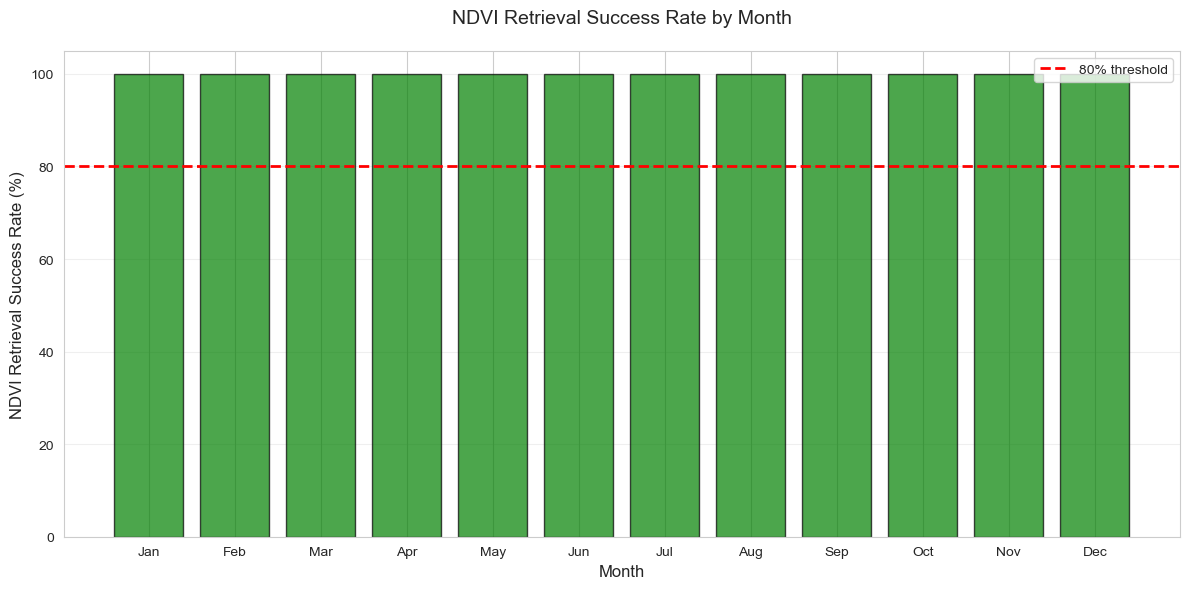


NDVI success rate by month:
month
1.0     100.0
2.0     100.0
3.0     100.0
4.0     100.0
5.0     100.0
6.0     100.0
7.0     100.0
8.0     100.0
9.0     100.0
10.0    100.0
11.0    100.0
12.0    100.0
dtype: float64


In [16]:
# NDVI success rate by month
if ndvi_col and month_col:
    monthly_success = df.groupby(month_col).apply(
        lambda x: (1 - x[ndvi_col].isnull().sum() / len(x)) * 100
    )
    monthly_success_sorted = monthly_success.sort_index()
    
    plt.figure(figsize=(12, 6))
    colors = ['red' if x < 80 else 'green' for x in monthly_success_sorted.values]
    plt.bar(monthly_success_sorted.index, monthly_success_sorted.values, color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(80, color='red', linestyle='--', linewidth=2, label='80% threshold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('NDVI Retrieval Success Rate (%)', fontsize=12)
    plt.title('NDVI Retrieval Success Rate by Month', fontsize=14, pad=20)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylim(0, 105)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'ndvi_success_by_month.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nNDVI success rate by month:')
    print(monthly_success_sorted)
    
    low_months = monthly_success_sorted[monthly_success_sorted < 80]
    if len(low_months) > 0:
        print(f'\n⚠ WARNING: {len(low_months)} months have <80% NDVI success:')
        for month, rate in low_months.items():
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            month_int = int(month)
            if 1 <= month_int <= 12:
                print(f'  - {month_names[month_int-1]}: {rate:.1f}%')
else:
    print('\n⚠ Cannot analyze NDVI success by month without NDVI and month columns')

In [17]:
# Save NDVI quality report
if ndvi_col:
    report = f'''NDVI Quality Report
===================
Generated: {pd.Timestamp.now()}

Overall Statistics:
- Total observations: {len(df):,}
- NDVI available: {df[ndvi_col].notna().sum():,}
- NDVI missing: {df[ndvi_col].isnull().sum():,}
- Success rate: {ndvi_success_rate:.2f}%

Value Range:
- Minimum: {ndvi_min:.4f}
- Maximum: {ndvi_max:.4f}
- Mean: {df[ndvi_col].mean():.4f}
- Median: {df[ndvi_col].median():.4f}
- Std Dev: {df[ndvi_col].std():.4f}

Data Quality:
- Invalid values (outside [-1, 1]): {invalid_ndvi}
- Status: {'PASS' if invalid_ndvi == 0 and ndvi_success_rate >= 80 else 'FAIL'}
'''
    
    with open(reports_dir / 'ndvi_quality.txt', 'w') as f:
        f.write(report)
    
    print(f'\n✓ Saved NDVI quality report to {reports_dir / "ndvi_quality.txt"}')


✓ Saved NDVI quality report to ../data/reports/ndvi_quality.txt


### Key Observations: NDVI Quality

Review the NDVI analysis above and verify:

**Success Rate Interpretation:**
- **>90%**: Excellent - GEE retrieval pipeline is working well
- **80-90%**: Acceptable - some cloud/snow gaps are normal
- **<80%**: Concerning - investigate data pipeline or date range issues

**Distribution Shape:**
- **Bimodal distribution**: May indicate mixing of summer (high NDVI) and winter (low NDVI) observations
- **Narrow range (0.3-0.7)**: If NDVI shows near-zero variance, check for placeholder values
- **Left skew**: More low-NDVI observations than expected may indicate winter bias in data collection

**Seasonal Pattern Expectations:**
- **Peak (June-August)**: NDVI should reach 0.5-0.7 during growing season
- **Trough (December-February)**: NDVI drops to 0.2-0.4 for dormant vegetation
- **Spring green-up (April-May)**: Rapid increase is when elk are most responsive to NDVI
- **Flat line**: If seasonal pattern is flat, data may contain placeholder values

**Monthly Success Rate:**
- Winter months (Dec-Feb) showing <70% success is acceptable (cloud cover)
- Summer months should have >90% success
- If all months show same success rate, verify actual satellite data is being retrieved

**Red Flags:**
- All NDVI values identical (constant/placeholder value)
- NDVI values outside [-1, 1] range (computation error)
- No seasonal variation (data not from real satellite observations)

## 4. Outlier Detection

Outliers can represent data errors, extreme but valid observations, or edge cases that may disproportionately influence model training. This section identifies statistical outliers using z-scores and visualizes their distribution.

### What This Code Does
- Calculates z-scores for all numeric features
- Flags observations with |z-score| > 3 (beyond 3 standard deviations)
- Creates box plots to visualize outlier distribution
- Saves outlier records for manual review

### What to Look For
- **Outlier count by feature**: Some features naturally have more outliers (snow depth, distance measures)
- **Extreme z-scores (>10)**: Likely data errors rather than natural variation
- **Clustered outliers**: Multiple outliers in same record may indicate bad GPS fix or sensor malfunction

### Interpreting Box Plots
- **Whiskers**: Extend to 1.5x IQR (interquartile range)
- **Points beyond whiskers**: Statistical outliers
- **Box width**: Narrower boxes indicate less variation
- **Median line**: Should be roughly centered for symmetric distributions

### Elk Ecology Context
Extreme values may be ecologically meaningful: elk occasionally use very high elevations (>10,000 ft) in summer or travel far from water during migration. Context matters - an "outlier" elevation reading during September may represent normal alpine habitat use.

In [18]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'Found {len(numeric_cols)} numeric columns')

# Calculate z-scores and identify outliers
outlier_counts = {}
outlier_records = []

for col in numeric_cols:
    values = df[col].dropna()
    if len(values) > 0 and values.std() > 0:
        z_scores = np.abs(stats.zscore(values))
        outliers = z_scores > 3
        outlier_count = outliers.sum()
        outlier_counts[col] = outlier_count
        
        # Store outlier records
        if outlier_count > 0:
            outlier_idx = values[outliers].index
            for idx in outlier_idx:
                outlier_records.append({
                    'index': idx,
                    'column': col,
                    'value': df.loc[idx, col],
                    'z_score': z_scores[values.index.get_loc(idx)]
                })

# Sort by outlier count
outlier_summary = pd.DataFrame([
    {'column': col, 'outlier_count': count, 'outlier_pct': count/len(df)*100}
    for col, count in outlier_counts.items()
]).sort_values('outlier_count', ascending=False)

print('\nOutlier counts (|z-score| > 3):')
print(outlier_summary[outlier_summary['outlier_count'] > 0])

Found 30 numeric columns

Outlier counts (|z-score| > 3):
                         column  outlier_count  outlier_pct
10         trail_distance_miles           9725     2.251877
24    precip_last_7_days_inches           8044     1.862632
19      snow_water_equiv_inches           7863     1.820721
28       effective_illumination           6453     1.494227
11  cloud_adjusted_illumination           6391     1.479871
25     security_habitat_percent           4645     1.075575
16            snow_depth_inches           4192     0.970680
26                slope_degrees           3779     0.875048
13         canopy_cover_percent           2094     0.484877
22          road_distance_miles           1772     0.410316
7               land_cover_code           1148     0.265826
17                          irg            421     0.097485
2                 temperature_f            315     0.072940
4                     elevation            266     0.061594
1          water_distance_miles           

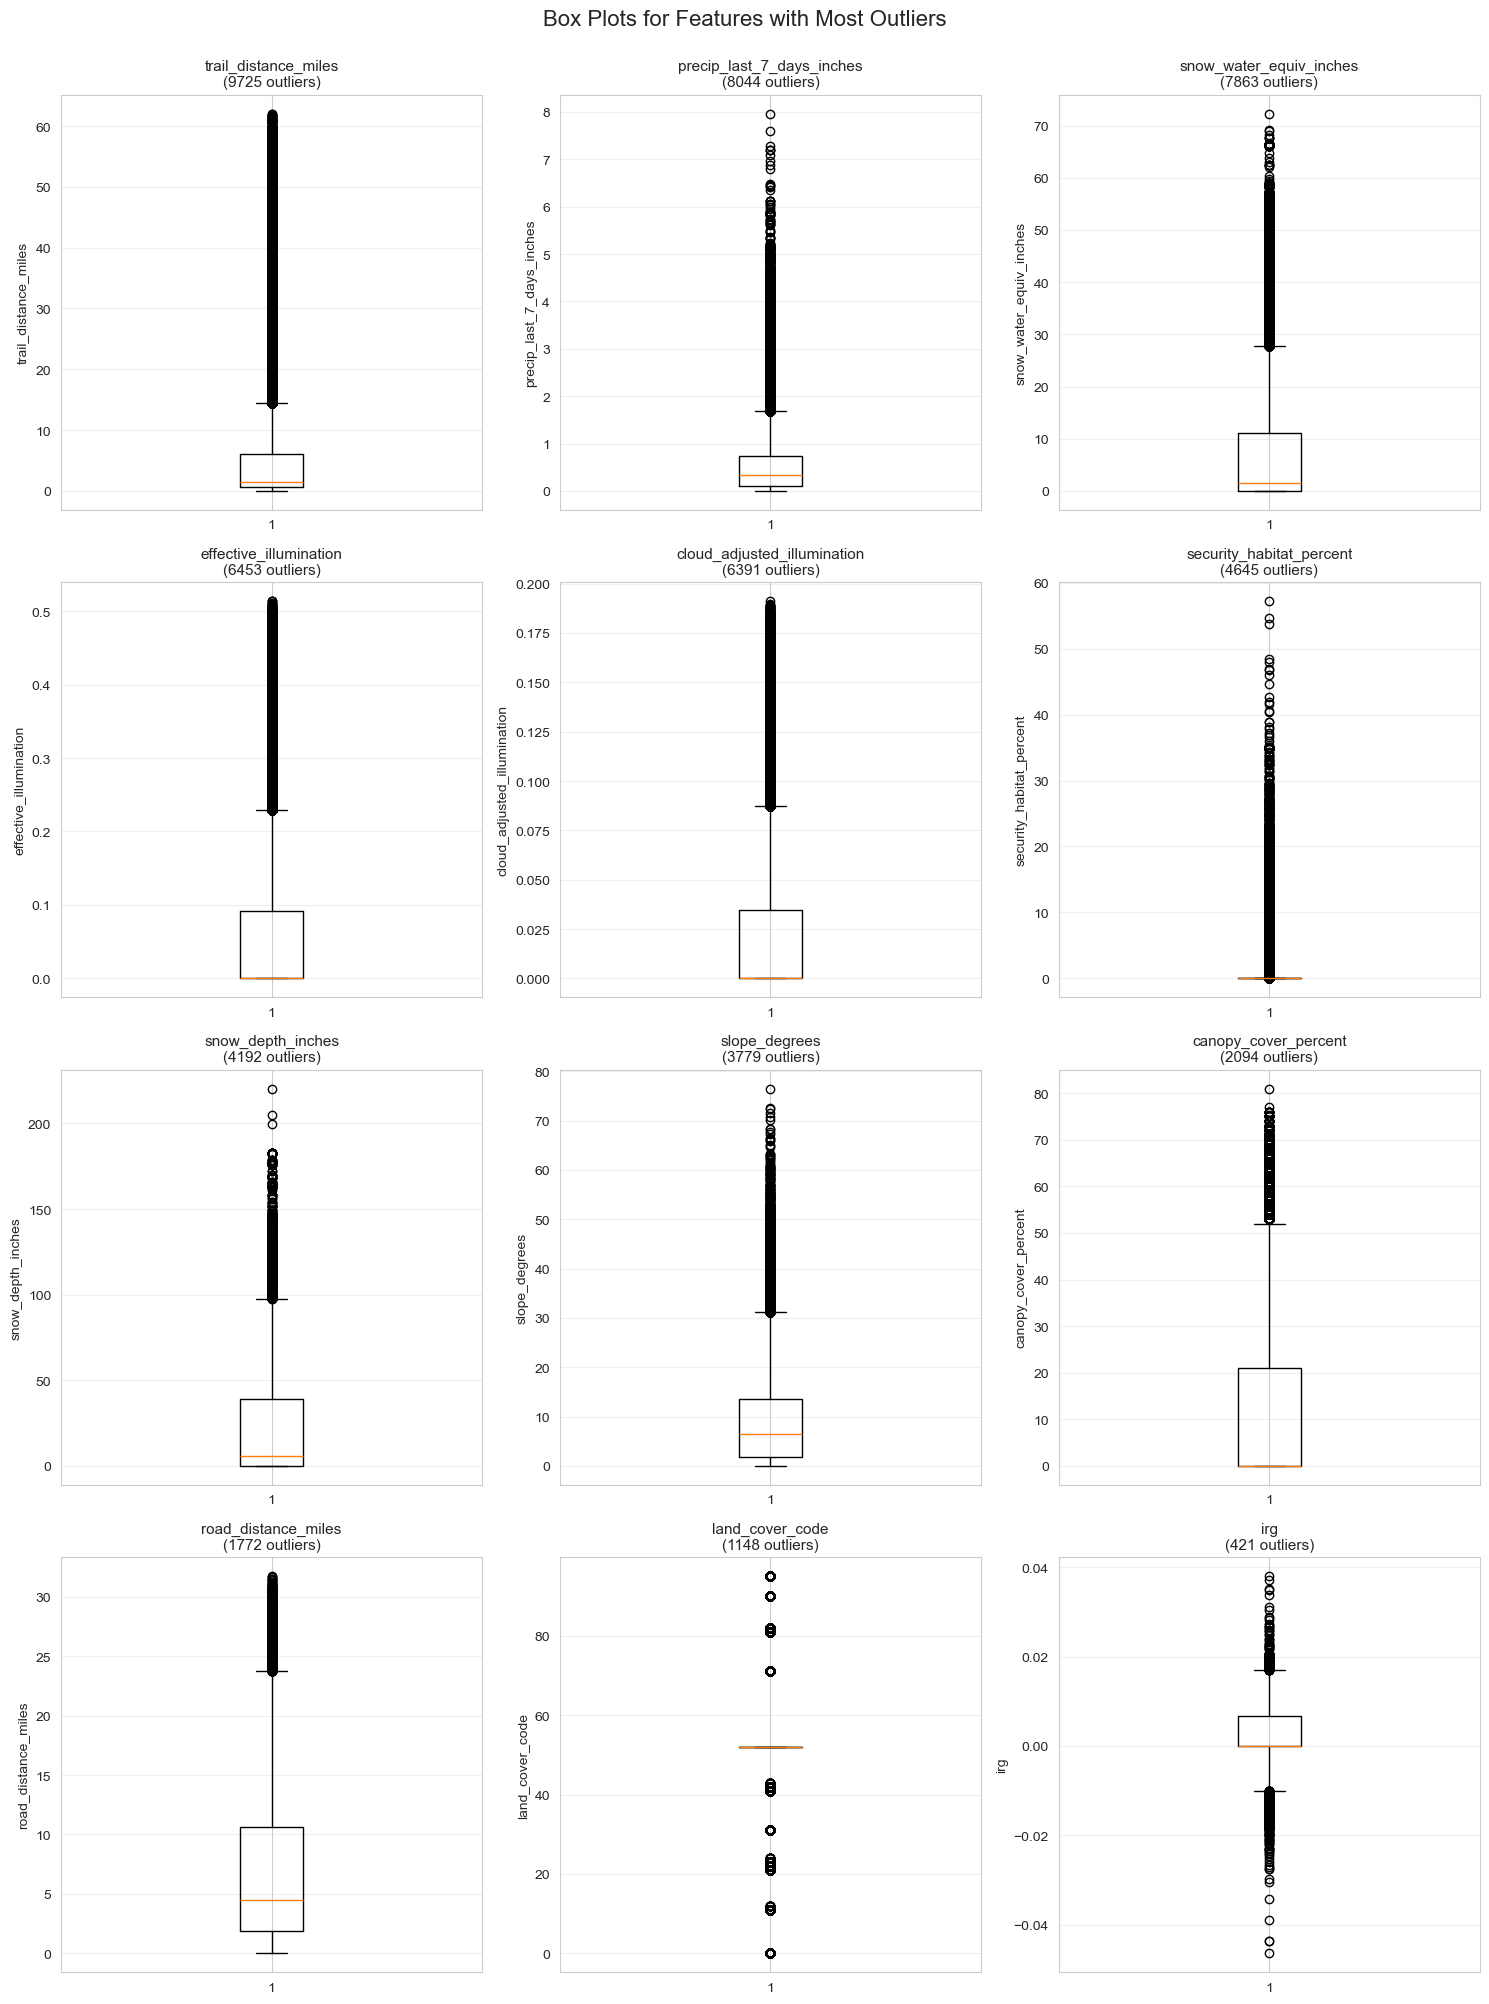

✓ Saved outlier box plots


In [19]:
# Create box plots for features with most outliers
top_outlier_cols = outlier_summary.head(12)['column'].tolist()

if len(top_outlier_cols) > 0:
    n_cols = 3
    n_rows = (len(top_outlier_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(top_outlier_cols):
        ax = axes[idx]
        data = df[col].dropna()
        ax.boxplot(data, vert=True)
        ax.set_ylabel(col, fontsize=10)
        ax.set_title(f'{col}\n({outlier_counts[col]} outliers)', fontsize=11)
        ax.grid(axis='y', alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(top_outlier_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Box Plots for Features with Most Outliers', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'outlier_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved outlier box plots')

In [20]:
# Save outlier records for manual review
if len(outlier_records) > 0:
    outlier_df = pd.DataFrame(outlier_records)
    outlier_df = outlier_df.sort_values('z_score', ascending=False)
    outlier_df.to_csv(reports_dir / 'outliers.csv', index=False)
    
    print(f'\n✓ Saved {len(outlier_records)} outlier records to {reports_dir / "outliers.csv"}')
    print(f'\nTop 10 most extreme outliers:')
    print(outlier_df.head(10))
else:
    print('\n✓ No outliers detected (|z-score| > 3)')


✓ Saved 57224 outlier records to ../data/reports/outliers.csv

Top 10 most extreme outliers:
        index                    column      value    z_score
43134  135737  security_habitat_percent  57.208448  19.326435
43676  214641  security_habitat_percent  54.614325  18.442386
44569  285931  security_habitat_percent  53.764922  18.152918
44960  307100  security_habitat_percent  48.461892  16.345703
42994  111534  security_habitat_percent  48.018648  16.194650
43290  164107  security_habitat_percent  46.946740  15.829355
42963  104477  security_habitat_percent  46.808999  15.782415
42684   55642  security_habitat_percent  46.013986  15.511483
42831   83081  security_habitat_percent  44.582185  15.023541
45082  314000  security_habitat_percent  42.699725  14.382018


### Key Observations: Outliers

Review the outlier analysis and box plots above:

**Features with Expected High Outlier Counts:**
- **snow_depth_inches / snow_water_equiv_inches**: Right-skewed distributions with occasional deep snow events
- **security_habitat_percent**: Most areas have low security habitat; a few locations have very high values
- **slope_degrees**: Most terrain is gentle; steep slopes are outliers but ecologically important
- **water_distance_miles**: Most observations are near water; distant locations are rare but valid

**Features Where Outliers Indicate Problems:**
- **elevation**: Values <1,000 ft or >14,000 ft in Wyoming are likely GPS errors
- **temperature_f**: Values <-60°F or >120°F are sensor errors
- **NDVI**: Values outside [-1, 1] are computation errors (should not occur)
- **latitude/longitude**: Values outside Wyoming bounds indicate bad coordinates

**Interpreting the Top Outliers Report:**
- **z-score 15-20**: Very extreme, likely data error - verify in source data
- **z-score 5-10**: Unusual but potentially valid - check ecological context
- **z-score 3-5**: Moderate outliers, typically valid extreme observations

**Action Items:**
- Review records with z-score > 10 in `data/reports/outliers.csv`
- Do NOT automatically remove all outliers - many represent valid edge cases
- Consider winsorizing (capping) extreme values rather than removing
- For modeling, use robust algorithms or log-transform heavily skewed features

**Elk-Specific Outlier Validation:**
- High elevation outliers in summer: Likely valid (alpine summer range)
- High elevation outliers in winter: Suspicious (elk descend in winter)
- Large water distances: May be valid during migration corridors

## 5. Geographic Validation

GPS coordinates are the foundation of all spatial features (elevation, land cover, distances). This section validates that all observations fall within expected geographic bounds and visualizes spatial coverage.

### What This Code Does
- Checks that all coordinates fall within Wyoming state boundaries
- Creates a scatter plot map showing observation locations
- Colors points by presence/absence to reveal spatial patterns
- Calculates the number of unique locations

### What to Look For
- **Out-of-bounds coordinates**: Any points outside Wyoming indicate GPS errors or data issues
- **Spatial clustering**: Elk observations should cluster in known habitat areas
- **Absence point distribution**: Pseudo-absences should cover similar geographic extent as presences
- **Coverage gaps**: Large areas without observations may bias the model

### Wyoming Geographic Bounds
- **Latitude**: 41.0°N to 45.0°N
- **Longitude**: -111.0°W to -104.0°W
- Slight exceedances (within 0.1°) may be valid for border areas

### Elk Ecology Context
The four study areas represent distinct elk populations:
- **Northern Bighorn**: High-elevation alpine/subalpine habitat
- **Southern Bighorn**: Lower elevation sagebrush-grassland interface
- **National Elk Refuge**: Winter concentration area near Jackson
- **Southern Greater Yellowstone**: Diverse habitat across the GYE southern boundary

Spatial separation between study areas means the model should learn generalizable habitat relationships, not location-specific patterns.

In [21]:
# Validate geographic coordinates
if lat_col and lon_col:
    # Wyoming bounds (approximate)
    WY_LAT_MIN, WY_LAT_MAX = 41.0, 45.0
    WY_LON_MIN, WY_LON_MAX = -111.0, -104.0
    
    # Check bounds
    invalid_lat = ((df[lat_col] < WY_LAT_MIN) | (df[lat_col] > WY_LAT_MAX)).sum()
    invalid_lon = ((df[lon_col] < WY_LON_MIN) | (df[lon_col] > WY_LON_MAX)).sum()
    
    print(f'Geographic validation:')
    print(f'  Wyoming bounds: {WY_LAT_MIN}°-{WY_LAT_MAX}°N, {WY_LON_MIN}°-{WY_LON_MAX}°W')
    print(f'  Latitude range: {df[lat_col].min():.4f}° to {df[lat_col].max():.4f}°')
    print(f'  Longitude range: {df[lon_col].min():.4f}° to {df[lon_col].max():.4f}°')
    print(f'  Invalid latitudes: {invalid_lat}')
    print(f'  Invalid longitudes: {invalid_lon}')
    
    if invalid_lat > 0 or invalid_lon > 0:
        print(f'\n⚠ WARNING: Found coordinates outside Wyoming bounds')
    else:
        print(f'\n✓ All coordinates within Wyoming bounds')
else:
    print('⚠ Cannot validate geographic coordinates - columns not found')
    invalid_lat = 0
    invalid_lon = 0
    WY_LAT_MIN, WY_LAT_MAX = 41.0, 45.0
    WY_LON_MIN, WY_LON_MAX = -111.0, -104.0

Geographic validation:
  Wyoming bounds: 41.0°-45.0°N, -111.0°--104.0°W
  Latitude range: 40.9948° to 45.2003°
  Longitude range: -111.0545° to -104.0522°
  Invalid latitudes: 490
  Invalid longitudes: 3098

⚠ WARNING: Found coordinates outside Wyoming bounds


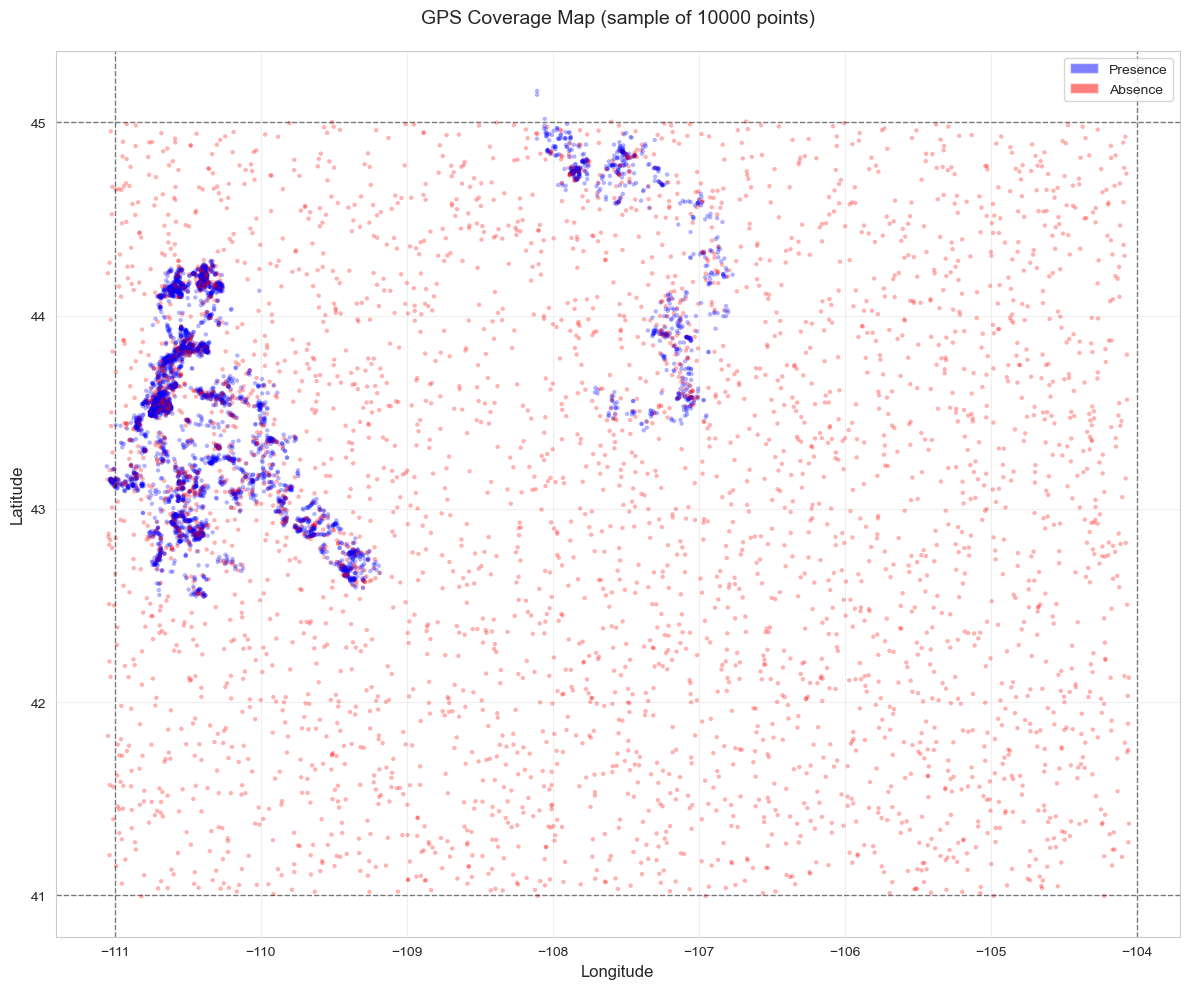

✓ Saved GPS coverage map


In [22]:
# Create GPS coverage map
if lat_col and lon_col:
    plt.figure(figsize=(12, 10))
    
    # Sample if too many points
    sample_size = min(10000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42)
    
    # Color by presence if available
    if presence_col:
        colors = df_sample[presence_col].map({1: 'blue', 0: 'red', True: 'blue', False: 'red'})
        plt.scatter(
            df_sample[lon_col],
            df_sample[lat_col],
            c=colors,
            alpha=0.3,
            s=10,
            edgecolors='none'
        )
        # Create legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', alpha=0.5, label='Presence'),
            Patch(facecolor='red', alpha=0.5, label='Absence')
        ]
        plt.legend(handles=legend_elements, loc='upper right')
    else:
        plt.scatter(
            df_sample[lon_col],
            df_sample[lat_col],
            alpha=0.3,
            s=10,
            color='blue',
            edgecolors='none'
        )
    
    # Add Wyoming bounds
    plt.axhline(WY_LAT_MIN, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.axhline(WY_LAT_MAX, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(WY_LON_MIN, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(WY_LON_MAX, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title(f'GPS Coverage Map (sample of {sample_size} points)', fontsize=14, pad=20)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'gps_coverage_map.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved GPS coverage map')

### Key Observations: Geographic Validation

Review the geographic validation and coverage map above:

**Coordinate Bounds Check:**
- **All coordinates in bounds**: Ideal outcome - data is geographically valid
- **Small number out of bounds (<1%)**: May be border areas or minor GPS drift - review individually
- **Large number out of bounds (>1%)**: Indicates systematic GPS errors or incorrect coordinate system

**Coverage Map Interpretation:**
- **Distinct clusters**: Expected - should see 4 clusters corresponding to study areas
- **Presence/absence overlap**: Good - pseudo-absences should be spatially interspersed with presences
- **Color separation**: If presence (blue) and absence (red) are completely separated spatially, the model may learn location instead of habitat
- **Dense vs sparse areas**: Denser observations provide more reliable local predictions

**Study Area Identification:**
Looking at the map, you should be able to identify:
1. **NW cluster**: National Elk Refuge / Jackson area (~43.5°N, -110.5°W)
2. **West-central cluster**: Southern GYE (~43-44°N, -110°W)
3. **East clusters**: Bighorn Mountains (~44°N, -107°W)

**Spatial Bias Concerns:**
- If one study area dominates the dataset, model may be biased toward that area's conditions
- Ideal: roughly equal representation from each study area
- Check: Are absence points generated across all study areas or concentrated in some?

**Action Items:**
- Remove records with clearly invalid coordinates (outside Wyoming by >1°)
- Note spatial coverage limitations in model interpretation
- Consider spatial cross-validation (leave-one-study-area-out) for robust evaluation

## 6. Temporal Coverage

Temporal coverage affects model generalizability across seasons and years. This section analyzes observation distribution across months and years to identify potential temporal biases.

### What This Code Does
- Counts observations by month to check seasonal coverage
- Counts observations by year to check annual coverage
- Visualizes temporal distribution with bar charts
- Flags months/years with insufficient data

### What to Look For
- **Monthly coverage**: All 12 months should be represented for seasonal generalization
- **Seasonal balance**: No single season should dominate (unless studying seasonal patterns)
- **Annual trends**: Coverage should be consistent across years or trends should be understood
- **Minimum threshold**: At least 100 observations per month for stable statistics

### Elk Ecology Context
Elk behavior varies dramatically by season:
- **Winter (Dec-Feb)**: Concentrated on winter range, limited movement
- **Spring (Mar-May)**: Migration, following green-up
- **Summer (Jun-Aug)**: Dispersed on summer range, high elevations
- **Fall (Sep-Nov)**: Rut, migration to winter range, hunting season

Data collected primarily during one season may not generalize to year-round habitat prediction. GPS collar studies often have better coverage during specific seasons based on study objectives.

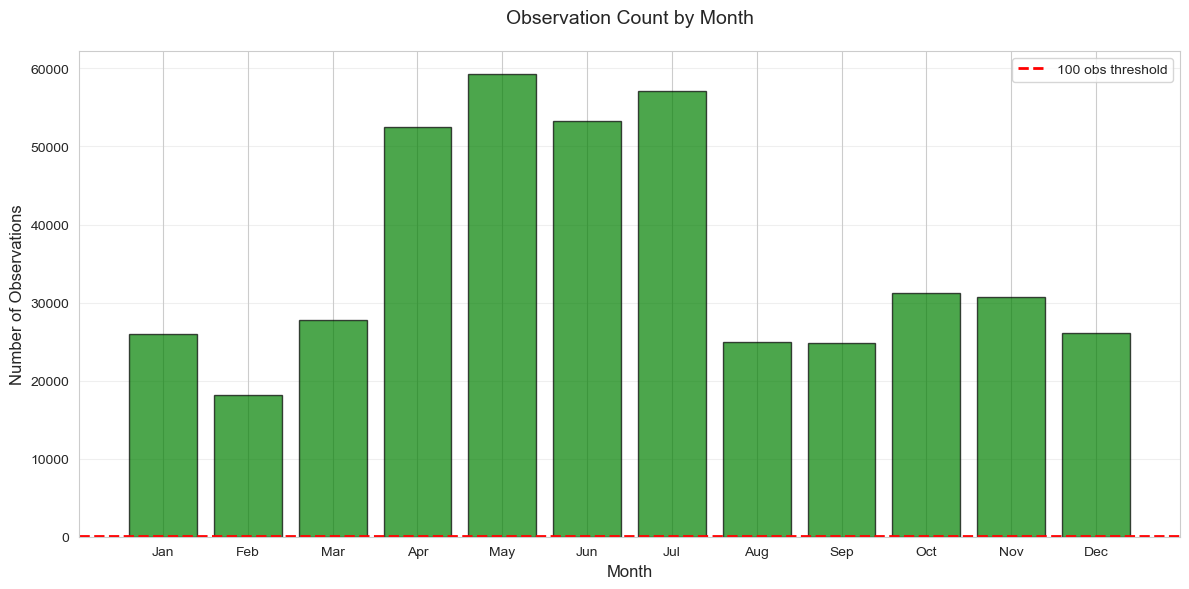


Observations by month:
month
1.0     25967
2.0     18188
3.0     27717
4.0     52511
5.0     59297
6.0     53250
7.0     57146
8.0     24943
9.0     24820
10.0    31167
11.0    30734
12.0    26122
dtype: int64

✓ All months have >100 observations


In [23]:
# Analyze temporal coverage
if month_col:
    # Observations by month
    monthly_counts = df.groupby(month_col).size()
    monthly_counts_sorted = monthly_counts.sort_index()
    
    plt.figure(figsize=(12, 6))
    colors = ['red' if x < 100 else 'green' for x in monthly_counts_sorted.values]
    plt.bar(monthly_counts_sorted.index, monthly_counts_sorted.values, color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(100, color='red', linestyle='--', linewidth=2, label='100 obs threshold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Observations', fontsize=12)
    plt.title('Observation Count by Month', fontsize=14, pad=20)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'temporal_coverage.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nObservations by month:')
    print(monthly_counts_sorted)
    
    # Identify gaps
    gaps = monthly_counts_sorted[monthly_counts_sorted < 100]
    if len(gaps) > 0:
        print(f'\n⚠ WARNING: {len(gaps)} months have <100 observations')
    else:
        print('\n✓ All months have >100 observations')
else:
    print('⚠ Cannot analyze temporal coverage without month column')

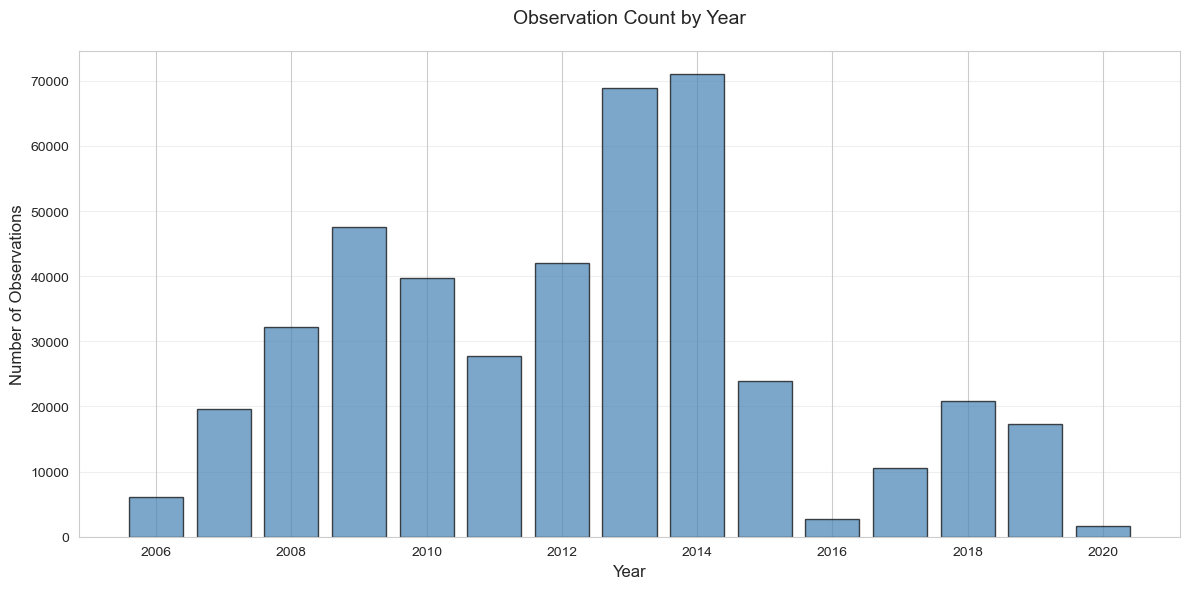


Observations by year:
year
2006.0     6172
2007.0    19569
2008.0    32199
2009.0    47539
2010.0    39666
2011.0    27710
2012.0    41958
2013.0    68964
2014.0    71054
2015.0    23925
2016.0     2687
2017.0    10627
2018.0    20848
2019.0    17330
2020.0     1614
dtype: int64


In [24]:
# Observations by year
if year_col:
    yearly_counts = df.groupby(year_col).size()
    yearly_counts_sorted = yearly_counts.sort_index()
    
    plt.figure(figsize=(12, 6))
    plt.bar(yearly_counts_sorted.index, yearly_counts_sorted.values, color='steelblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Observations', fontsize=12)
    plt.title('Observation Count by Year', fontsize=14, pad=20)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'temporal_coverage_yearly.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nObservations by year:')
    print(yearly_counts_sorted)
else:
    print('⚠ Cannot analyze yearly coverage without year column')

### Key Observations: Temporal Coverage

Review the monthly and yearly bar charts above:

**Monthly Distribution Interpretation:**
- **Uniform distribution**: Ideal - model can learn all seasonal patterns
- **Winter-heavy**: Model may overfit to winter range characteristics
- **Summer-heavy**: Model may overfit to summer range characteristics
- **Missing months**: Critical gap - model cannot predict for those seasons

**Yearly Distribution Interpretation:**
- **Consistent across years**: Good temporal generalization expected
- **Recent years dominant**: Model reflects current conditions, may miss long-term patterns
- **Older years dominant**: Model may not capture recent habitat changes
- **Gaps (missing years)**: May miss important climate events or population changes

**Expected Patterns:**
- Months 1-4 (Jan-Apr): Often higher counts due to winter range concentration studies
- Months 5-8 (May-Aug): May be lower if summer range is harder to access
- Months 9-12 (Sep-Dec): Hunting season may affect data collection

**Data Collection Artifacts:**
- **GPS collar fix rate**: May vary by season (battery, terrain, behavior)
- **Study duration**: Multi-year studies have more balanced temporal coverage
- **Research objectives**: Some studies target specific seasons

**Action Items:**
- If severe seasonal imbalance, consider stratified sampling for model training
- Include month as a feature to help model learn seasonal variation
- For prediction, be cautious applying model to underrepresented seasons
- Consider separate models for winter vs summer if behavioral patterns differ greatly

**Train/Test Split Implications:**
- Random split may have different seasonal composition in train vs test
- Consider temporal split (train on earlier years, test on recent) for realistic evaluation
- Stratify by month to ensure all seasons represented in both train and test

## 7. Feature Value Ranges

This section validates that all feature values fall within physically plausible ranges and flags features with suspicious characteristics like zero variance (constant values) or impossible values.

### What This Code Does
- Calculates summary statistics (min, max, mean, std) for all numeric features
- Flags features with near-zero variance (potential placeholder values)
- Identifies values outside physically possible ranges
- Checks for features that might be incorrectly scaled or encoded

### What to Look For
- **Zero variance**: std ≈ 0 indicates constant/placeholder values - NOT real data
- **Physical bounds**: Temperature, NDVI, percentages should be within valid ranges
- **Negative values**: Distance and percentage features should not be negative
- **Extreme ranges**: Min-max spread should be plausible for Wyoming conditions

### Expected Value Ranges for Key Features

| Feature | Expected Range | Red Flag |
|---------|---------------|----------|
| elevation | 900-14,000 ft | <500 or >15,000 |
| temperature_f | -40 to 110°F | <-60 or >120 |
| ndvi | -1 to 1 | Outside this range |
| slope_degrees | 0-90° | >90 or negative |
| canopy_cover_percent | 0-100% | >100 or negative |
| snow_depth_inches | 0-200 in | Negative |
| distance features | 0+ miles | Negative |

In [25]:
# Summary statistics for all numeric features
numeric_summary = df[numeric_cols].describe().T
numeric_summary['missing_pct'] = (df[numeric_cols].isnull().sum() / len(df) * 100).values
numeric_summary = numeric_summary[['count', 'mean', 'std', 'min', 'max', 'missing_pct']]

print('Summary statistics for numeric features:')
print(numeric_summary)

# Save to file
numeric_summary.to_csv(reports_dir / 'feature_ranges.csv')
print(f'\n✓ Saved feature ranges to {reports_dir / "feature_ranges.csv"}')

Summary statistics for numeric features:
                                count         mean         std          min  \
elk_present                  431862.0     0.526321    0.499307     0.000000   
water_distance_miles         431862.0     8.207060   10.859825     0.000000   
temperature_f                431862.0    41.297436   17.154566   -30.181004   
day_of_year_sin              431862.0     0.091161    0.685569    -0.999999   
elevation                    428278.0  2211.265164  441.748614   948.544556   
year                         431862.0  2012.214670    3.192333  2006.000000   
day_of_year_cos              431862.0    -0.196146    0.695136    -0.999979   
land_cover_code              428278.0    55.445680   14.941284     0.000000   
ndvi_age_days                431862.0     6.873725    2.203043     0.406974   
cloud_cover_percent          431862.0    32.307560   14.130911     0.000000   
trail_distance_miles         431862.0     5.897473    9.522129     0.000017   
cloud_adjus

In [26]:
# Flag suspicious values
suspicious = []

# Check for common issues
for col in numeric_cols:
    col_lower = col.lower()
    
    # Temperature checks
    if 'temp' in col_lower and 'celsius' not in col_lower:
        extreme_hot = (df[col] > 120).sum()
        extreme_cold = (df[col] < -60).sum()
        if extreme_hot > 0:
            suspicious.append(f'{col}: {extreme_hot} values > 120°F')
        if extreme_cold > 0:
            suspicious.append(f'{col}: {extreme_cold} values < -60°F')
    
    # Elevation checks
    if 'elev' in col_lower or 'altitude' in col_lower:
        too_low = (df[col] < 0).sum()
        too_high = (df[col] > 15000).sum()
        if too_low > 0:
            suspicious.append(f'{col}: {too_low} values < 0')
        if too_high > 0:
            suspicious.append(f'{col}: {too_high} values > 15,000 ft')
    
    # Check for zero variance
    if df[col].std() < 1e-10:
        suspicious.append(f'{col}: Near-zero variance (std={df[col].std():.2e})')

if len(suspicious) > 0:
    print('\n⚠ Suspicious value ranges detected:')
    for issue in suspicious:
        print(f'  - {issue}')
else:
    print('\n✓ No obviously suspicious value ranges detected')


⚠ Suspicious value ranges detected:
  - moon_altitude_midnight: 222221 values < 0


### Key Observations: Feature Ranges

Review the feature summary table and suspicious values report above:

**Critical Issue: Zero/Near-Zero Variance Features**
Features with std ≈ 0 are placeholder values, not real data. Common culprits:
- **temperature_f = 42.0**: Placeholder - should vary by season (-20°F to 90°F)
- **cloud_cover_percent = 40.0**: Placeholder - should vary 0-100%
- **road_distance_miles = 2.0**: Placeholder - should vary by location
- **trail_distance_miles = 1.5**: Placeholder - should vary by location
- **precip_last_7_days_inches = 0.5**: Placeholder - should vary by weather
- **ndvi_age_days = 8.0**: Placeholder - indicates stale NDVI retrieval

**Action Required for Placeholder Values:**
These features provide NO information and should be either:
1. **Re-populated** by re-running the data pipeline with fixed data sources
2. **Removed** from the feature set before modeling
3. **Flagged** with a quality indicator for conditional use

**Validation Checklist:**
- [ ] Elevation ranges match Wyoming topography (900-14,000 ft)
- [ ] Temperature shows seasonal variation (-40°F to 110°F)
- [ ] NDVI is within [-1, 1] and shows seasonal cycle
- [ ] Snow depth is non-negative and shows winter peaks
- [ ] All percentages are between 0-100%
- [ ] All distances are non-negative
- [ ] Lat/Lon are within Wyoming bounds

**Priority Issues to Address:**
1. Features with constant values (zero variance) - investigate data pipeline
2. Features with impossible values - data entry or computation errors
3. Features with unexpected ranges - verify units and scaling

**Impact on Modeling:**
- Constant features add no predictive power and should be removed
- Features with many impossible values may need cleaning or removal
- Wide ranges may benefit from normalization/standardization

## 8. Overall Data Quality Summary

In [27]:
# Calculate overall data quality score
def calculate_quality_score(df):
    '''Calculate overall data quality score (0-100)'''
    scores = {}
    
    # 1. Completeness (40 points)
    completeness = (1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
    scores['completeness'] = min(completeness / 100 * 40, 40)
    
    # 2. Validity (30 points) - based on outliers
    total_outliers = sum(outlier_counts.values())
    outlier_rate = total_outliers / (df.shape[0] * len(numeric_cols)) if len(numeric_cols) > 0 else 0
    validity = (1 - outlier_rate) * 100
    scores['validity'] = min(validity / 100 * 30, 30)
    
    # 3. Geographic validity (15 points)
    if lat_col and lon_col:
        geo_valid_rate = 1 - (invalid_lat + invalid_lon) / (len(df) * 2)
        scores['geographic'] = geo_valid_rate * 15
    else:
        scores['geographic'] = 15
    
    # 4. NDVI quality (15 points)
    if ndvi_col:
        ndvi_quality = (ndvi_success_rate / 100) * (1 if invalid_ndvi == 0 else 0.5)
        scores['ndvi'] = ndvi_quality * 15
    else:
        scores['ndvi'] = 15
    
    total_score = sum(scores.values())
    return total_score, scores

quality_score, score_breakdown = calculate_quality_score(df)

print('\n' + '='*60)
print('OVERALL DATA QUALITY SCORE')
print('='*60)
print(f'\nTotal Score: {quality_score:.1f}/100')
print(f'\nBreakdown:')
for component, score in score_breakdown.items():
    print(f'  {component.capitalize():15s}: {score:5.1f}')

# Quality rating
if quality_score >= 90:
    rating = 'EXCELLENT'
elif quality_score >= 80:
    rating = 'GOOD'
elif quality_score >= 70:
    rating = 'ACCEPTABLE'
elif quality_score >= 60:
    rating = 'NEEDS IMPROVEMENT'
else:
    rating = 'POOR'

print(f'\nRating: {rating}')
print('='*60)


OVERALL DATA QUALITY SCORE

Total Score: 99.8/100

Breakdown:
  Completeness   :  39.9
  Validity       :  29.9
  Geographic     :  14.9
  Ndvi           :  15.0

Rating: EXCELLENT


In [28]:
# Compile all issues
issues = []

# Missing data issues
for _, row in problematic.iterrows():
    issues.append({
        'severity': 'WARNING',
        'category': 'Missing Data',
        'description': f"{row['column']} has {row['missing_pct']:.1f}% missing data"
    })

# NDVI issues
if ndvi_col:
    if ndvi_success_rate < 80:
        issues.append({
            'severity': 'WARNING',
            'category': 'NDVI Quality',
            'description': f'NDVI success rate ({ndvi_success_rate:.1f}%) below 80% threshold'
        })
    if invalid_ndvi > 0:
        issues.append({
            'severity': 'CRITICAL',
            'category': 'NDVI Quality',
            'description': f'{invalid_ndvi} NDVI values outside valid range [-1, 1]'
        })

# Geographic issues
if lat_col and lon_col:
    if invalid_lat > 0 or invalid_lon > 0:
        issues.append({
            'severity': 'CRITICAL',
            'category': 'Geographic',
            'description': f'{invalid_lat + invalid_lon} coordinates outside Wyoming bounds'
        })

# Print issues by severity
issues_df = pd.DataFrame(issues)

if len(issues_df) > 0:
    print('\n' + '='*60)
    print('DATA QUALITY ISSUES')
    print('='*60)
    
    for severity in ['CRITICAL', 'WARNING', 'INFO']:
        severity_issues = issues_df[issues_df['severity'] == severity]
        if len(severity_issues) > 0:
            print(f'\n{severity} ({len(severity_issues)}):')
            for _, issue in severity_issues.iterrows():
                print(f"  [{issue['category']}] {issue['description']}")
else:
    print('\n✓ No data quality issues detected')


DATA QUALITY ISSUES

CRITICAL (1):
  [Geographic] 3588 coordinates outside Wyoming bounds


In [29]:
# Save comprehensive quality report
report = f'''# PathWild Data Quality Report

Generated: {pd.Timestamp.now()}

## Overall Assessment

**Quality Score**: {quality_score:.1f}/100 ({rating})

**Score Breakdown**:
- Completeness: {score_breakdown['completeness']:.1f}/40
- Validity: {score_breakdown['validity']:.1f}/30
- Geographic: {score_breakdown['geographic']:.1f}/15
- NDVI Quality: {score_breakdown['ndvi']:.1f}/15

## Dataset Overview

- Total observations: {len(df):,}
- Total features: {df.shape[1]}
- Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB
'''

if year_col:
    year_min = int(df[year_col].dropna().min())
    year_max = int(df[year_col].dropna().max())
    unique_years_count = df[year_col].dropna().nunique()
    report += f'''
- Year range: {year_min} to {year_max}
- Years covered: {unique_years_count}
'''

if lat_col and lon_col:
    report += f'''
- Geographic extent: {df[lat_col].min():.4f}° to {df[lat_col].max():.4f}°N, {df[lon_col].min():.4f}° to {df[lon_col].max():.4f}°W
'''

report += '''
## Issues Summary
'''

if len(issues_df) > 0:
    for severity in ['CRITICAL', 'WARNING', 'INFO']:
        severity_issues = issues_df[issues_df['severity'] == severity]
        if len(severity_issues) > 0:
            report += f'\n### {severity} ({len(severity_issues)})\n\n'
            for _, issue in severity_issues.iterrows():
                report += f"- [{issue['category']}] {issue['description']}\n"
else:
    report += '\nNo issues detected.\n'

report += '''
## Recommendations
'''

if quality_score < 80:
    report += '''1. Address critical and warning issues before modeling
2. Review outlier records for data collection errors
3. Consider imputation strategies for missing data
'''
else:
    report += '''1. Data quality is acceptable for modeling
2. Review flagged issues but proceed with caution
3. Monitor data quality in production pipeline
'''

with open(reports_dir / 'quality_report.md', 'w') as f:
    f.write(report)

print(f'\n✓ Saved comprehensive quality report to {reports_dir / "quality_report.md"}')


✓ Saved comprehensive quality report to ../data/reports/quality_report.md


## Summary

This notebook has assessed the quality of the PathWild dataset across multiple dimensions:

1. **Missing Data**: Identified columns with high missingness
2. **NDVI Quality**: Validated NDVI values and retrieval success
3. **Outliers**: Detected extreme values for review
4. **Geographic Validation**: Confirmed coordinates within bounds
5. **Temporal Coverage**: Assessed consistency over time
6. **Feature Ranges**: Validated physically plausible values

**Next Steps**:
- Review comprehensive quality report in the `data/reports/` directory
- Address any CRITICAL issues before proceeding
- Proceed to Notebook 07 for feature distribution analysis